# Easy 21: prediction
[(source code)](https://github.com/angelolovatto/rl-introduction-notebooks/blob/master/notebooks/Easy21%20-%20Prediction.ipynb)

The goal of this assignment is to apply Model-Free Prediction methods to a simple card game based on David Silver RL assignment Easy21. This exercise is similar to the Blackjack example in Sutton and Barto 5.3 – please note, however, that the rules of the card game are different and non- standard.
* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement).
    * Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
    * There are no aces or picture (face) cards in this game.
* At the start of the game both the player and the dealer draw one black card (fully observed).
* Each turn the player may either stick or hit.
    * If the player hits then she draws another card from the deck.
    * If the player sticks she receives no further cards.
* The values of the player’s cards are added (black cards) or subtracted (red cards).
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1).
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In this assignment, we want to learn the state-value function for a given policy $\pi$ i.e., we want to learn $v_\pi(s)$, $\forall s \in\mathcal{S}$, that is the expected return starting from state $s$. Consider the policy $\pi$ that sticks if the player’s sum is 20 or 21, and otherwise hits, plus other player’s policies of your choice. For each of the 2 policies, and for each algorithm, plot the optimal value function $v_\pi$ using similar axes to the Figure 5.2 (right) from Sutton and Barto’s book.

## 1. Implementation of Easy21 simulator

You should write an environment that implements the game Easy21. Specifically, write a function, named `step`, which takes as input a state s (dealer’s first card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns a sample of the next state s′ (which may be terminal if the game is finished) and reward r. We will be using this environment for prediction and for control (in the next part of this PE) and you should not explicitly represent the transition matrix for the MDP. There is no discounting ($\gamma = 1$). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

---

The following is an implementation of the _Easy21_ environment, where two conventions were adopted:
* $A_t \in \{0, 1\}$, where 0 and 1 denote _stick_ and _hit_ respectively;
* $S_t = (s_d, s_p) \in \{0, \dots, 9\}\times\{0, \dots, 20\}$, where $s_d$ and $s_p$ denote the dealer's first card and the player's card sum, both subtracted by 1.

These conventions were used in order to adapt the implementation to OpenAI's Gym specifications. In the plots that follow, the dealer's first card and the player's sum are shifted in order to appear in the ranges 1-10 and 1-21 respectively.

In [1]:
import gym
import random
from gym import spaces

class Easy21Env(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(10), spaces.Discrete(21)))
        self.action_space = spaces.Discrete(2)
        self.random = random.Random()
        
    def reset(self):
        self.state = (self.random.randrange(10), self.random.randrange(10))
        self.done = False
        return self.state
    
    def _draw_card(self):
        new_card = self.random.randrange(1, 11)
        return new_card if self.random.uniform(0, 1) > 1/3 else - new_card
    
    @staticmethod
    def _is_bust(card_sum):
        return card_sum not in range(21)

    def step(self, action):
        assert action in self.action_space
        assert not self.done, \
        "It looks like you're calling step() even though this "
        "environment has already returned done=True. You should "
        "always call reset() once you receive done=True."
        dealer_card, player_sum = self.state
        if action is 1:
            player_sum += self._draw_card()
            is_bust = self._is_bust(player_sum)
            self.state = (dealer_card, player_sum) if not is_bust else self.state
            reward = -1 if is_bust else 0
            self.done = is_bust
        else:
            dealer_sum = dealer_card
            while not self._is_bust(dealer_sum) and dealer_sum < 16:
                dealer_sum += self._draw_card()
            is_bust = self._is_bust(dealer_sum)
            sum_diff = player_sum - dealer_sum
            self.state = self.state 
            reward = 1 if is_bust or sum_diff > 0 else 0 if sum_diff is 0 else -1
            self.done = True
        return self.state, reward, self.done, {}
    
    def seed(self, seed=None):
        self.random.seed(seed)

Below are utility functions to handle state and action spaces

In [2]:
from itertools import product

def elements(space):
    if isinstance(space, spaces.Tuple):
        return product(*(elements(subspace) for subspace in space))
    elif isinstance(space, spaces.Discrete):
        return range(space.n)
    else:
        raise ValueError(
            "Unsupported observation space type: {}".format(type(space)))

def all_states(env):
    return elements(env.observation_space)

def all_actions(env):
    return elements(env.action_space)

def all_state_action_pairs(env):
    return product(all_states(env), all_actions(env))

def shape(space):
    if isinstance(space, spaces.Tuple):
        return sum((shape(subspace) for subspace in space), ())
    elif isinstance(space, spaces.Discrete):
        return (space.n,)
    else:
        raise ValueError(
            "Unsupported observation space type: {}".format(type(space)))    

def states_shape(env):
    return shape(env.observation_space)

def actions_shape(env):
    return shape(env.action_space)

def states_actions_shape(env):
    return states_shape(env) + actions_shape(env)

def vpi_array_from_dict(vpi):
    arr = np.empty(states_shape(env))
    for state in all_states(env):
        arr[state] = vpi[state]
    return arr

The main policy which we will evaluate in this environment is one that allways hits when the player's sum is below 20 and always sticks otherwise. We also include a custom policy, as requested, which hits when the player's sum is less than the dealer's first card plus 10.

In [3]:
env = Easy21Env()
main_policy = lambda state: 1 if state[1] < 19 else 0
custom_policy = lambda state: 1 if state[1] < 10 + state[0] else 0

## 2. Monte-Carlo Prediction

Apply Monte-Carlo prediction to Easy21. Follow the First-visit MC prediction algorithm from Sutton and Barto’s book (page 92), modified with the following incremental Monte Carlo value- update (from Lecture 4 of David Silver) for each state $S_t$ with return $G_t$:

$$
N(S_t) \gets N(S_t) + 1
$$
$$
V(S_t) \gets V(S_t) + \frac{1}{N(S_t)} \left( G_t - V(S_t)\right),
$$

where $\alpha_t = 1/N(S_t)$ is the time-varying scalar step-size, $N(S_t)$ is the number of times that state $S_t$ has been visited and $V(S_t)$ is the estimate of the true value $v_\pi(S_t)$. Initialise the value function to zero. Stop each run after 1000 episodes.

---

Below we implement a counter to keep track of how many times a state has been visited. Every time it is called for a state $S_t$, it increments its number of visits and returns the updated $N(S_t)$ to the caller. Notice that in first-visit Monte-Carlo prediction, we only call this for the first time we encounter a state in a particular episode.

For Monte-Carlo (MC) prediction, we need to wait for each episode to finish in order to calculate the returns. Thus, the policy evaluation step is done for each timestep $t$ of the episode once it has finished.

In [4]:
import numpy as np
from tqdm import tnrange
from collections import defaultdict


class VisitCounter(object):
    def __init__(self):
        self.visits = defaultdict(int)
        
    def __call__(self, *args):
        self.visits[args] += 1
        return self.visits[args]

def monte_carlo_prediction(env, policy, episodes):
    # Initialize all state values to 0
    value = dict.fromkeys(all_states(env), 0)
    # Keep a counter of the number of visits to each state
    first_visits = VisitCounter()
    
    for episode in tnrange(episodes, disable=True, desc='Progress', unit='episodes'):
        # Generate an episode following policy
        done, state = False, env.reset()
        trajectory = []
        while not done:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            
        # Precompute the returns for each timestep
        states, _, rewards = zip(*trajectory)
        returns = np.cumsum(rewards[::-1])[::-1].tolist()
        visited_states = set()
        # for each step of the episode, update the state value
        for state, _return in zip(states, returns):
            if state in visited_states:
                continue
            visited_states.add(state)
            value[state] += (1/first_visits(state)) * (_return - value[state])
            
    return vpi_array_from_dict(value)

Next we define code used to plot a 3D visualization of the value function.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter, MaxNLocator


def state_value_data(vpi):
    x = np.arange(10) + 1
    y = np.arange(21) + 1
    x, y = np.meshgrid(x, y)
    return x, y, vpi.transpose()

def state_value_desc(ax, labels=True):
    if labels:
        ax.set_xlabel("Dealer's card")
        ax.set_ylabel("Player's sum")
        ax.set_zlabel("State value")
    ax.set_xlim([1, 10])
    ax.set_ylim([1, 21])
    ax.set_zlim([-1, 1])
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

def state_value_surface(ax, vpi):
    ax.plot_surface(*state_value_data(vpi), cmap=cm.coolwarm)

def state_value_wireframe(ax, vpi, labels=True):
    ax.plot_wireframe(*state_value_data(vpi))

def vpi_x_episodes(prediction_algorithm, policy, **alg_kwargs):
    vpis = []
    for i in range(6):
        env.seed(42)
        vpis.append(prediction_algorithm(env, policy, 10**(i+1), **alg_kwargs))
    return vpis

def plot_vpi_episodes(vpis):
    fig = plt.figure(figsize=[19.2, 9.6])
    for i, vpi in enumerate(vpis):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        ax.set_title("{} episodes".format(10**(i+1)))
        state_value_desc(ax, labels=(i==5))
        state_value_wireframe(ax, vpi)

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

Below we plot the estimated values for non-terminal states after different number of episodes using Monte-Carlo prediction.

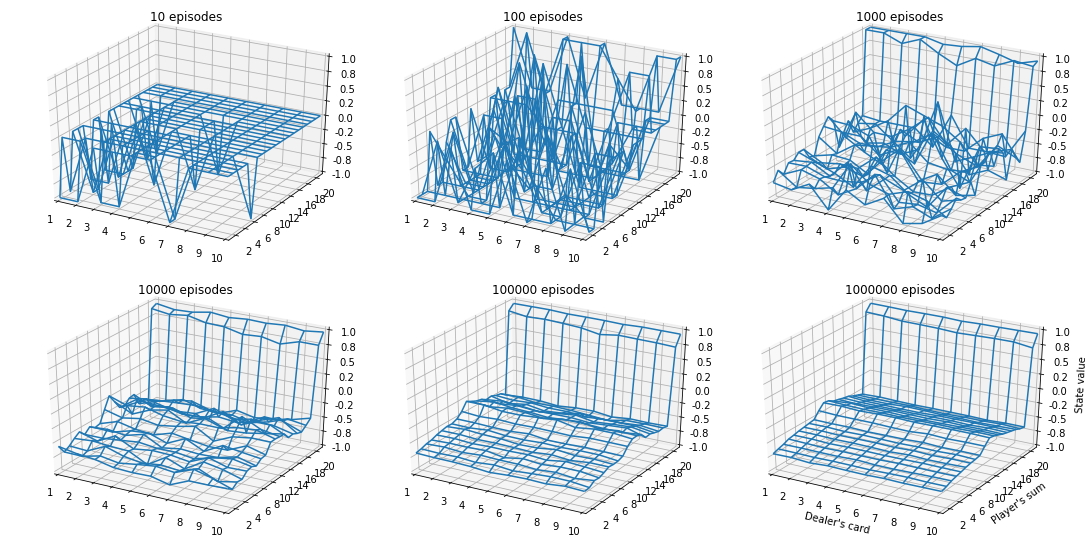

In [6]:
mc_vpis_main = vpi_x_episodes(monte_carlo_prediction, main_policy)
plot_vpi_episodes(mc_vpis_main)

Note that the relative bump in value observed in states which have the player's sum between 10 and 12 may be due to the fact that the probability of going bust in these states is very low. If the sum is 10 or 12, then the player can only go bust immediately by receiving cards of values -10 and +10 respectively. Furthermore, if the sum is 11 the player can never go bust immediately and has a small chance of receiving +10 and ending up with 21. 

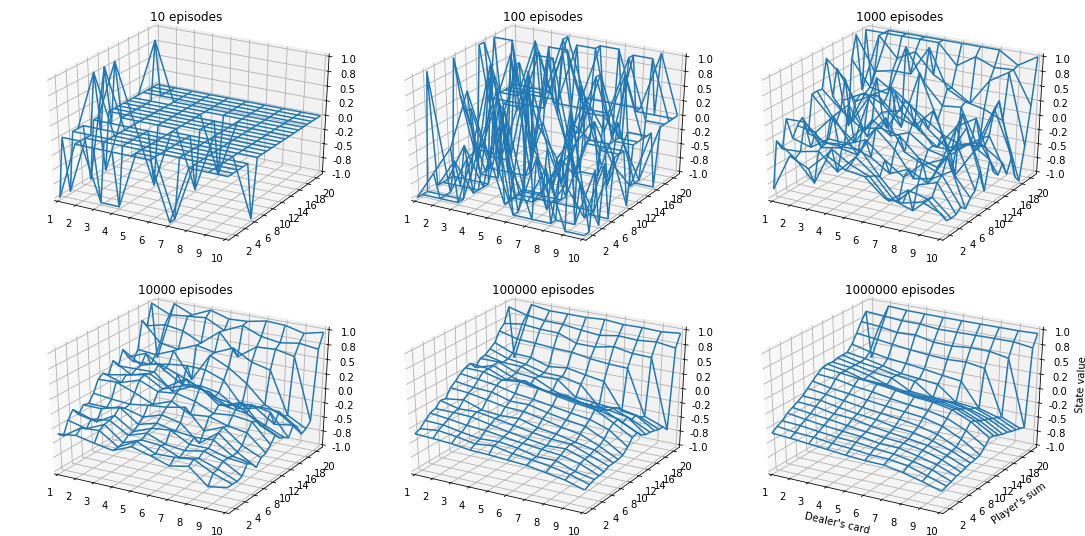

In [7]:
mc_vpis_custom = vpi_x_episodes(monte_carlo_prediction, custom_policy)
plot_vpi_episodes(mc_vpis_custom)

Notice that the value function obtained for the custom policy tends to be lower for states where the dealer's first card is higher. This makes sense: the policy only sticks if the player has a sum which is 10 points higher than the dealer's card, which is more difficult to achieve when this card has a higher value.

Furthermore, notice that the value of the state $(1, 21)$ is zero, which probably means the state was never visited. Indeed, to get to 21 the player must have had a sum of at least 11 in the previous step (in which case it must receive a black 10 card to end up with 21), which is already 10 plus the dealer's intial card. Thus, the policy will always stick before the player's sum gets to 21 in this case.

## 3. TD(0) Prediction

Implement TD(0) prediction to Easy21. Follow the 1-step update value V(St) toward estimated return from Lecture 4 of David Silver:

$$
V(S_t) \gets V(S_t) + \alpha_t\left( R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right),
$$

where $\alpha_t = 1/N(S_t)$ is the time-varying scalar step-size, $N(S_t)$ is the number of times that state $S_t$ has been visited and $V(S_t)$ is the estimate of the true value $v_\pi(S_t)$. Initialise the value function to zero. Use γ=1 and stop each run after 1000 episodes.

---

We implement TD(0) prediction below and update state-value estimates towards the _TD target_ as indicated above. Notice that we set the next state value to zero if it is terminal. 

One of the advantages of TD(0) over MC is that the update above can be applied after each transition, without the need to wait for episodes to finish. Thus, the implementation below updates the state-value estimates (policy evaluation step) while interacting with the environment, making the code much shorter than the one used for MC.

In [8]:
def td_zero_prediction(env, policy, episodes):
    # Initialize all state values to 0
    value = dict.fromkeys(all_states(env), 0)
    # Keep a counter of the number of visits to each state
    visits = VisitCounter()
    
    for episode in tnrange(episodes, disable=True, desc='Progress', unit='episodes'):
        done, state = False, env.reset()
        while not done:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            
            next_state_value = 0 if done else value[next_state]
            value[state] += (1/visits(state))*(
                reward + next_state_value - value[state])
            
            state = next_state
            
    return vpi_array_from_dict(value)

Below we plot the estimated values for non-terminal states after different number of episodes using TD(0) prediction.

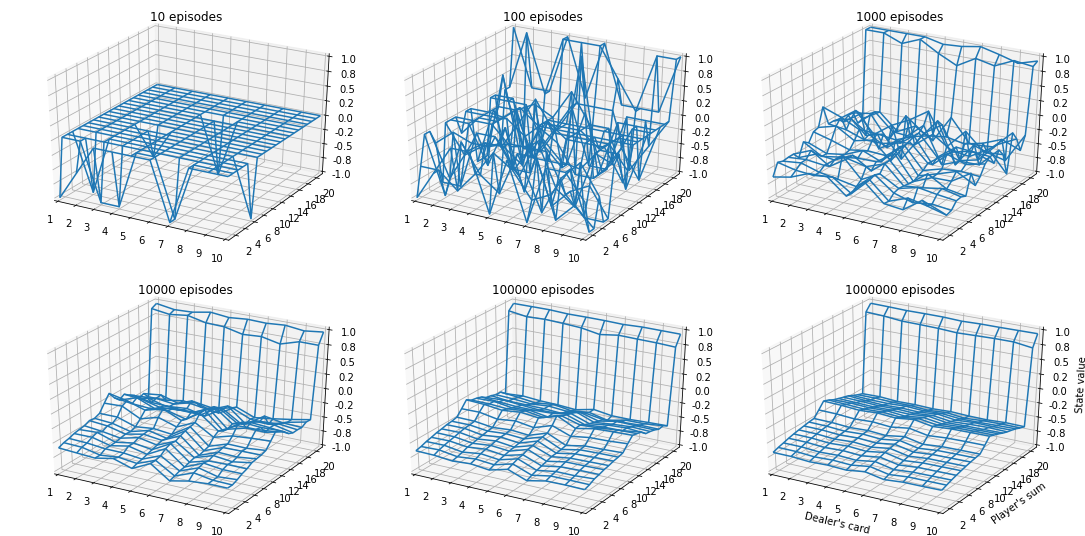

In [9]:
td0_vpis_main = vpi_x_episodes(td_zero_prediction, main_policy)
plot_vpi_episodes(td0_vpis_main)

No significant difference between the results given by TD(0) and MC were observed. However, it does seem that the value function returned by TD(0) after 100000 episodes is smoother than the one returned by MC. 

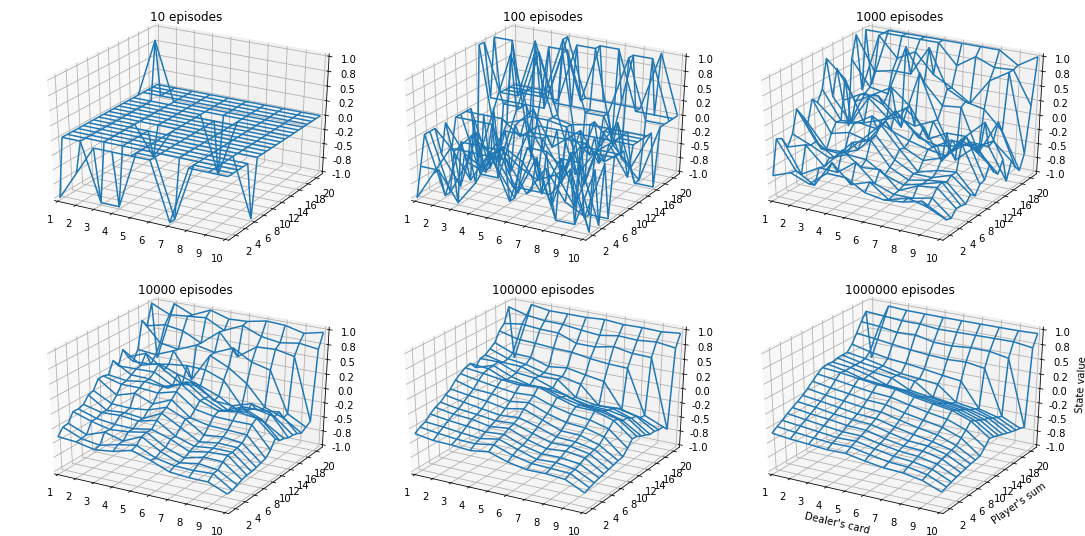

In [10]:
td0_vpis_custom = vpi_x_episodes(td_zero_prediction, custom_policy)
plot_vpi_episodes(td0_vpis_custom)

Again, the results returned by TD(0) are very similar to the ones returned by MC.

Next we compare the value functions for the main policy returned after 100000 episodes.

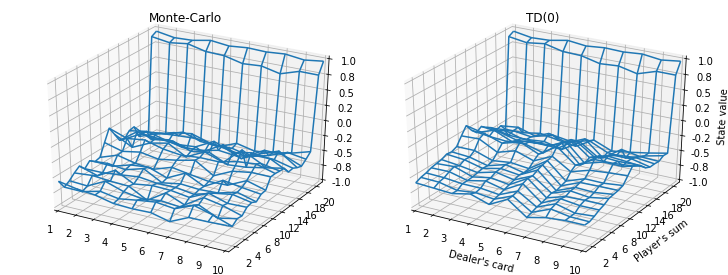

In [11]:
fig = plt.figure(figsize=[12.8, 4.8])
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("Monte-Carlo")
state_value_desc(ax, labels=False)
state_value_wireframe(ax, mc_vpis_main[3])

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("TD(0)")
state_value_desc(ax)
state_value_wireframe(ax, td0_vpis_main[3])

plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

In this comparison, it seems that TD(0) is converging faster to the true value function, while the MC result seems to be a bit noisier.

## 4. TD($\lambda$) Prediction

Implement TD($\lambda$) prediction to Easy21. Follow the $\lambda$-return $G_t^\lambda$ from Lecture 4 of David Silver:

$$
G_t^\lambda = (1-\lambda) \sum_{n=1}^{\infty} \lambda^{n-1} G_t^{(n)},
$$
and the forward-view TD(λ) update:
$$
V(S_t) \gets V(S_t) + \alpha_t \left( G_t^\lambda - V(S_t) \right).
$$

Use the same step-size as in the previous sections. Run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, \dots, 1\}$. Stop each run after 1000 episodes. Plot the mean-squared error against $\lambda$. For $\lambda = 0$ and $\lambda = 1$ only, plot the learning curve of mean-squared error against episode number.

---

We implement TD($\lambda$) below for estimating the state-value function of our policy. This algorithm combines long-term returns with bootstrapping by calculating the $\lambda$ return defined above, where
$$
G_t^{(n)} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{n-1} R_{t+n} + \gamma^n V(S_{t+n}).
$$

In order to calculate the n-step returns $G_t^{(n)}$, we need to wait until the end of each episode. Thus, the algorithm below is similar to the MC algorithm, since both have separate loops for generating an episode, computing the returns and updating the value estimates. However, we chose to update state-values on every visit to a state, similar to TD(0). 

Finally, the update rule uses the same step-size used in the previous algorithms: $\alpha_t = 1/N(S_t)$

In [12]:
def n_step_return(n, states, rewards, value):
    n_sum_rewards = sum(rewards[:n])
    n_state_value = value[states[n]] if n < len(states) else 0
    return n_sum_rewards + n_state_value

def td_lambda_prediction(env, policy, episodes, *, lam=1, callback=None):
    # Initialize all state values to 0
    value = dict.fromkeys(all_states(env), 0)
    # Keep a counter of the number of visits to each state
    visits = VisitCounter()
    
    for episode in tnrange(episodes, disable=True, desc='Progress', unit='episodes'):
        # Generate an episode following policy
        done, state = False, env.reset()
        trajectory = []
        while not done:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            
        states, _, rewards = zip(*trajectory)
        for t, state in enumerate(states):
            _states, _rewards = states[t:], rewards[t:]
            lam_return = (1-lam) * sum(
                lam**(n-1) * n_step_return(n, _states, _rewards, value)
                for n in range(1,len(_rewards))
            ) + lam**(len(_rewards)-1) * sum(_rewards)
            value[state] += (1/visits(state)) * (lam_return - value[state])

        if callback is not None:
            callback(vpi_array_from_dict(value))
    return vpi_array_from_dict(value)

In order to find out what the best values of $\lambda$ are for this task, we first calculate the value function, which we'll consider as $V^\pi$, given by MC prediction after 100000 episodes of experience. Second, we estimate the value function using TD($\lambda$) with 1000 episodes, for $\lambda\in\{0, 0.1, 0.2, \dots, 0.9, 1\}$, which returns $V$. Finally, we plot the mean squared error between each TD($\lambda$) estimate and $V^\pi$:

$$
    \frac{1}{|\mathcal{S}|}\sum_{s\in\mathcal{S}} \left( V(s) - V^\pi(s) \right)^2.
$$

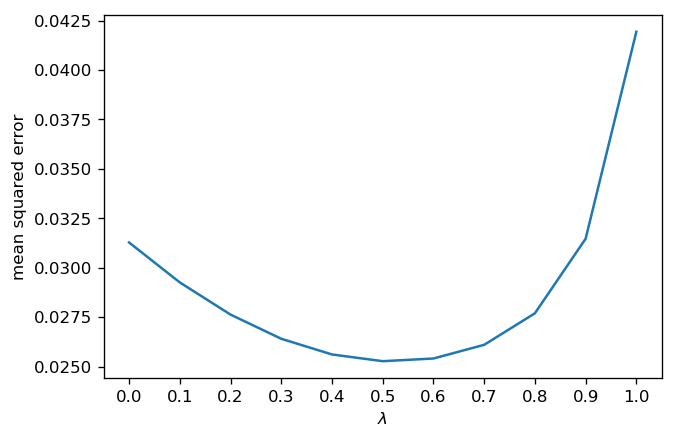

In [16]:
def mean_squared_error(arr1, arr2):
    return np.square(arr1 - arr2).mean().item()

env.seed(42)
mc_vpi = monte_carlo_prediction(env, main_policy, 100000)
lambdas = list(x/10 for x in range(11))
errors = []
for lam in lambdas:
    env.seed(42)
    lam_vpi = td_lambda_prediction(env, main_policy, 1000, lam=lam)
    errors.append(mean_squared_error(lam_vpi, mc_vpi))

fig = plt.figure(dpi=120)
plt.plot(lambdas, errors)
plt.xticks(lambdas)
plt.xlabel("$\lambda$")
plt.ylabel("mean squared error")
plt.show()

It is interesting that the error varies smoothly with different values of $\lambda$. Next, we plot the value functions obtained by TD($\lambda$) with different number of episodes and $\lambda = 0.5$, which seemed to be the best value.

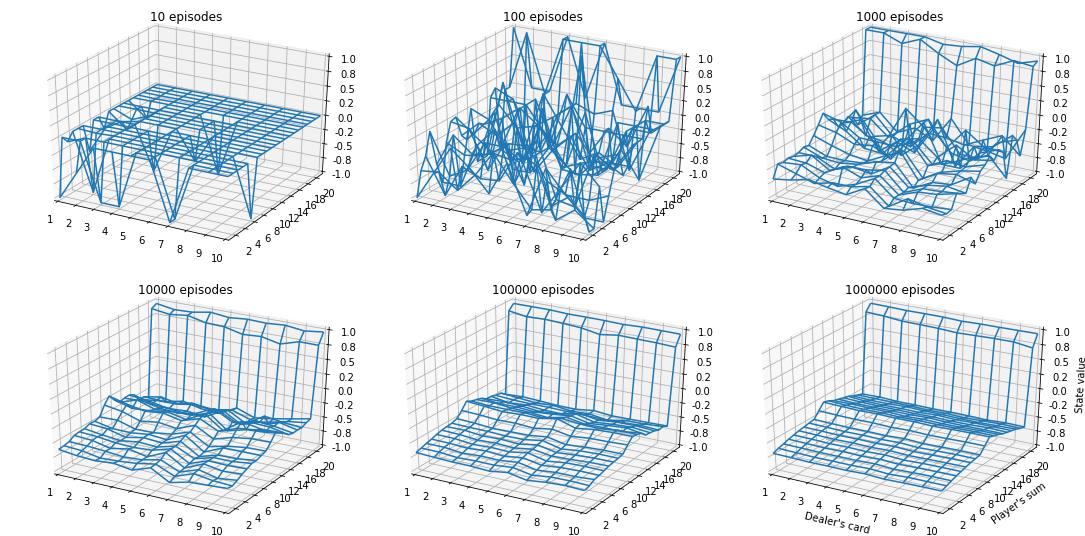

In [17]:
tdlam_vpis_main = vpi_x_episodes(td_lambda_prediction, main_policy, lam=0.5)
plot_vpi_episodes(tdlam_vpis_main)

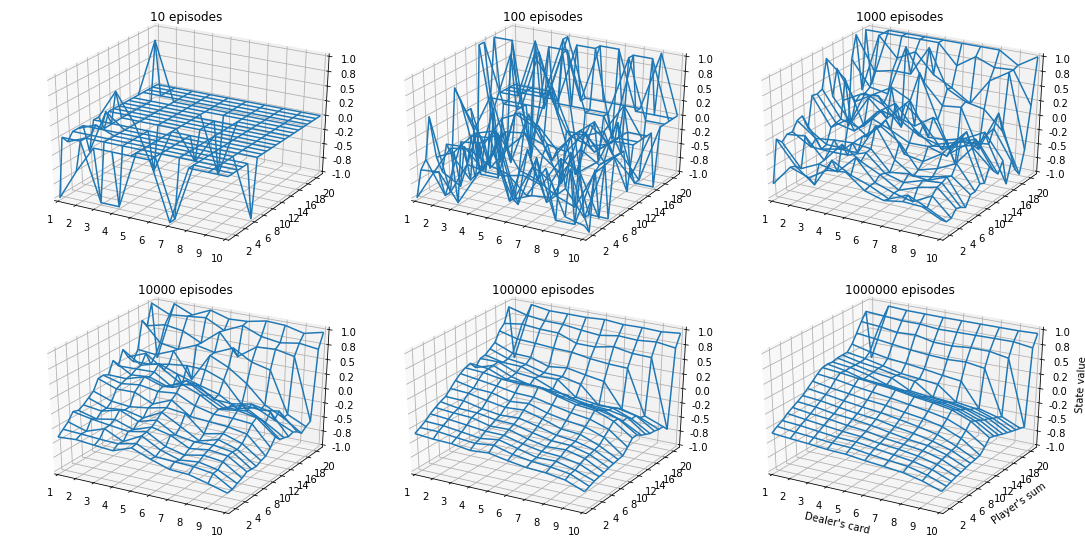

In [18]:
tdlam_vpis_custom = vpi_x_episodes(td_lambda_prediction, custom_policy, lam=0.5)
plot_vpi_episodes(tdlam_vpis_custom)

We also plot the mean squared error between the same $V^\pi$ as above and the value functions obtained by TD($\lambda$), for $\lambda\in\{0, 1\}$, against the number of episodes. Notice that the algorithm obtained a lower error faster with the lower value of $\lambda$.

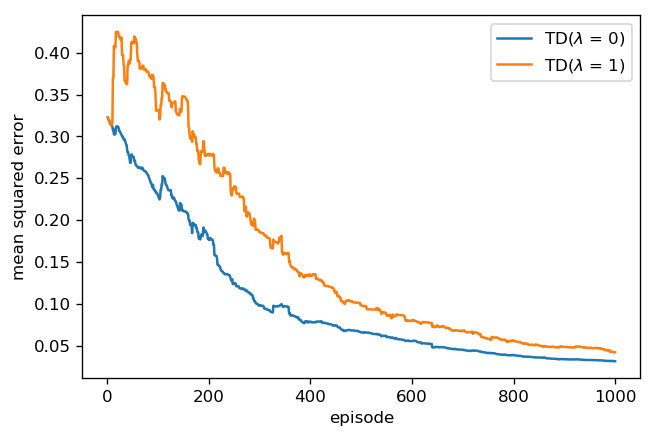

In [19]:
errors0 = []
def callback(value):
    errors0.append(mean_squared_error(value, mc_vpi))
env.seed(42)
td_lambda_prediction(env, main_policy, 1000, lam=0, callback=callback)

errors1 = []
def callback(value):
    errors1.append(mean_squared_error(value, mc_vpi))
env.seed(42)
td_lambda_prediction(env, main_policy, 1000, lam=1, callback=callback)

fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, 1001), errors0, '-', label='TD($\lambda$ = 0)')
ax.plot(range(1, 1001), errors1, '-', label='TD($\lambda$ = 1)')
ax.set_xlabel('episode')
ax.set_ylabel('mean squared error')
ax.legend()

plt.show()

## 5. Discussion

### What are the pros and cons of bootstrapping in Easy21:prediction?
I noticed that bootstrapping seems to result in lower variance estimates (as predicted by Silver in his classes), judging by the smoothness of the values functions obtained by the bootstrapping methods. Furthermore, TD(0) is considerably shorter to implement than MC.

However TD($\lambda$), another bootstrapping algorithm, ended up being the most complicated to implement. Its forward-view estimation of $G_t^\lambda$ requires waiting for each episode to complete and computing an expensive weighted sum with several passes through the sequence of rewards.

### Would you expect bootstrapping to help more in blackjack or Easy21:prediction? Why?
The length of the episodes in Easy21:prediction can be longer than the ones in blackjack, since cards can either add or subtract to the player's sum, potentially making it ocillate for a while before either the player goes bust or sticks. I expect bootstrapping to be more helpful in Easy21:prediction because of this, since we saw in the last classes that Monte Carlo methods exhibit high variance with longer episodes. Bootstrapping should help address this issue by replacing part of the long sequence of rewards necessary to calculate $G_t$ with a value estimate of a subsequent state or state-action pair.

### Verify that TD($\lambda\to0$) is equivalent to TD(0).

In order to assess how close the algorithms are, we plot their final value functions after 10000 episodes and the mean squared error between the estimates. We decided against using more episodes since both algorithms could converge and thus no meaninful differences would be observed.

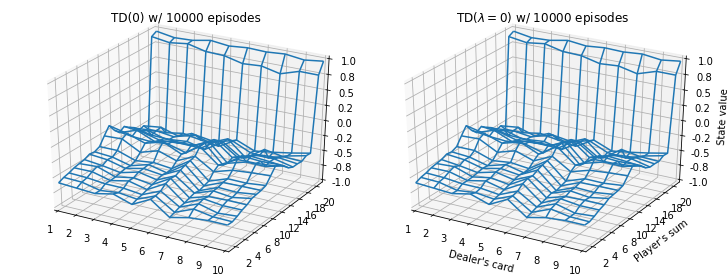

In [20]:
env.seed(42)
vpi0 = td_zero_prediction(env, main_policy, 10000)
env.seed(42)
vpilam = td_lambda_prediction(env, main_policy, 10000, lam=0)

fig = plt.figure(figsize=[12.8, 4.8])
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("TD(0) w/ 10000 episodes")
state_value_desc(ax, labels=False)
state_value_wireframe(ax, vpi0)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("TD($\lambda = 0$) w/ 10000 episodes")
state_value_desc(ax)
state_value_wireframe(ax, vpilam)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [21]:
print("Mean squared error between the values obtained:", mean_squared_error(vpi0, vpilam))

Mean squared error between the values obtained: 0.0


### Verify that TD($\lambda\to1$) is equivalent to MC.
We do the same as above, this time comparing MC to TD($\lambda = 1$)

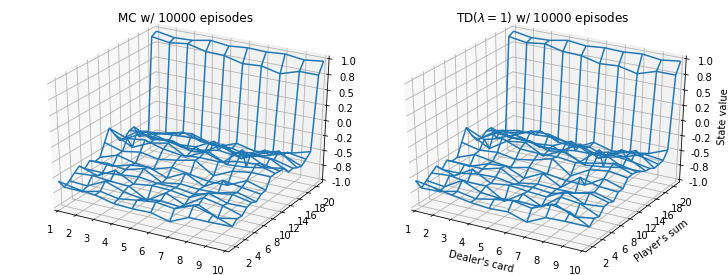

In [22]:
def plot_mc_vs_tdlam():
    env.seed(42)
    vpimc = monte_carlo_prediction(env, main_policy, 10000)
    env.seed(42)
    vpilam = td_lambda_prediction(env, main_policy, 10000, lam=1)

    fig = plt.figure(figsize=[12.8, 4.8])
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title("MC w/ 10000 episodes")
    state_value_desc(ax, labels=False)
    state_value_wireframe(ax, vpimc)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title("TD($\lambda = 1$) w/ 10000 episodes")
    state_value_desc(ax)
    state_value_wireframe(ax, vpilam)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    return vpimc, vpilam
    
vpimc, vpilam = plot_mc_vs_tdlam()

In [23]:
print("Mean squared error between the values obtained:", mean_squared_error(vpimc, vpilam))

Mean squared error between the values obtained: 0.0002679971489425752


The algorithms are not equivalent because TD($\lambda$) was implemented to update state-values on every visit to a state, while MC updates them on first-visit only. Re-implementing TD($\lambda$) to use first-visit should solve this issue.

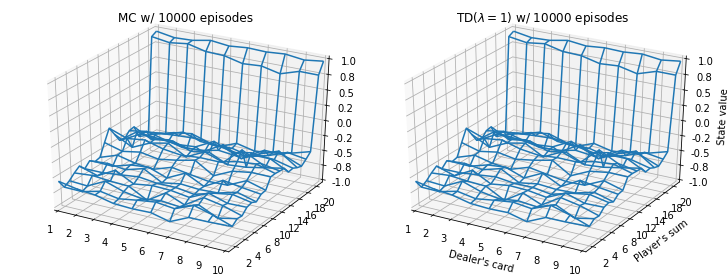

In [25]:
def td_lambda_prediction(env, policy, episodes, *, lam=1, callback=None):
    # Initialize all state values to 0
    value = dict.fromkeys(product(range(10), range(21)), 0)
    # Keep a counter of the number of visits to each state
    first_visits = VisitCounter()
    
    for episode in tnrange(episodes, disable=True, desc='Progress', unit='episodes'):
        # Generate an episode following policy
        done, state = False, env.reset()
        trajectory = []
        while not done:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            
        # for each step of the episode, update the state value
        states, _, rewards = zip(*trajectory)
        visited_states = set()
        for t, state in enumerate(states):
            if state in visited_states:
                continue
            visited_states.add(state)

            _states, _rewards = states[t:], rewards[t:]
            lam_return = (1-lam) * sum(
                lam**(n-1) * n_step_return(n, _states, _rewards, value)
                for n in range(1,len(_rewards))
            ) + lam**(len(_rewards)-1) * sum(_rewards)
            value[state] += (1/first_visits(state)) * (lam_return - value[state])
            
        if callback is not None:
            callback(vpi_array_from_dict(value))
    return vpi_array_from_dict(value)

vpimc, vpilam = plot_mc_vs_tdlam()

In [26]:
print("Mean squared error between the values obtained:", mean_squared_error(vpimc, vpilam))

Mean squared error between the values obtained: 0.0
